In [ ]:
import numpy as np
import pandas as pd
import graphviz
import lingam
from lingam.utils import print_causal_directions, print_dagc, make_dot
from utilities import generate_connection_matrix, sample_uniform_noise, generate_dataset, sample_from_disjoint_interval

In [112]:
import random

def perturb_adjacency_matrix(matrix, n=1, mode='both'):
    """
    Perturbs a weighted adjacency matrix by adding/removing edges,
    preserving causal order (i.e., j < i for edge j → i).

    Parameters:
    - matrix: np.ndarray, square weighted adjacency matrix
    - n: number of edges to add/remove
    - mode: 'add', 'remove', or 'both'
    - weight_range: tuple, range of weights to assign when adding edges

    Returns:
    - new_matrix: np.ndarray, perturbed matrix
    """

    new_matrix = matrix.copy()
    num_nodes = new_matrix.shape[0]
    
    # Collect removable and addable edges
    removable_edges = [(i, j) for i in range(num_nodes) for j in range(i) if new_matrix[i, j] != 0]
    addable_edges = [(i, j) for i in range(num_nodes) for j in range(i) if new_matrix[i, j] == 0]
    
    if mode in ['remove', 'both']:
        to_remove = random.sample(removable_edges, min(n, len(removable_edges)))
        for i, j in to_remove:
            new_matrix[i, j] = 0.0

    if mode in ['add', 'both']:
        to_add = random.sample(addable_edges, min(n, len(addable_edges)))
        for i, j in to_add:
            weight = sample_from_disjoint_interval(1)[0]
            new_matrix[i, j] = weight

    return new_matrix

In [89]:
%load_ext autoreload
%autoreload 2

In [90]:
p=5 # number of features 
s=0.5 # edge probability
n=10000 # number of samples
c=3 #number of groups
B=generate_connection_matrix(p, s) # connection matrix 

In [143]:
P = [100, 150, 200] # number of variables/features
S = [0.2, 0.25, 0.3] # edge probabilities (control the sparsity)
C = 4 #number of groups
PERT = 0.15 #perturbation level

[403, 413, 304, 323]

In [139]:
p = np.random.choice(P)
s = np.random.choice(S)
N = [np.random.randint(int(1.2 * p), int(2.5 * p)) for _ in range(4)]
B = generate_connection_matrix(p, s)
groups_matrix = []
for c in range(0,C):
    #calculate the number of edges that we want to perturb
    n_perturbations = int(np.count_nonzero(B)* PERT)
    #create the matrix by perturbing the original matrix
    group_B = perturb_adjacency_matrix(B, n_perturbations,"both")
    #add the connection matrix to the list
    groups_matrix.append(group_B)

    





4

In [110]:
np.count_nonzero(B)


1257

In [199]:
variances = np.random.uniform(low=1,high=3,size=p)

In [200]:
E = sample_uniform_noise(n, 5, variances)

In [201]:
X, m, perm_ = generate_dataset(E, B, permutation=None)

In [203]:
m

array([ 0.492608  , -0.4916362 , -0.05906891,  1.63714322,  2.03941558])

In [204]:
perm_

array([4, 2, 0, 1, 3])

## Estimating back

In [1]:
import numpy as np
import pandas as pd
import graphviz
import lingam
from lingam.utils import print_causal_directions, print_dagc, make_dot

In [205]:
#now we can retrieve the causal graph given the generated dataset.
model = lingam.DirectLiNGAM()
model.fit(X)

In [217]:
inverse_perm = np.argsort(perm_)
B_est_original_order = model.adjacency_matrix_[inverse_perm, :][:, inverse_perm]

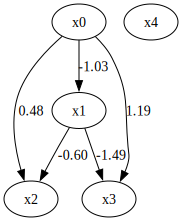

In [218]:
make_dot(B_est_original_order)

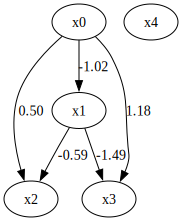

In [208]:
make_dot(B)

In [209]:
B

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [-1.01544738,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.50055843, -0.58787966,  0.        ,  0.        ,  0.        ],
       [ 1.18449243, -1.49077568,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

## Matrix Perturbation


In [ ]:




import networkx as nx

def get_causal_order(matrix):
    G = nx.DiGraph()
    num_nodes = matrix.shape[0]

    # Add edges from matrix
    for i in range(num_nodes):
        for j in range(num_nodes):
            if matrix[i, j] != 0:
                G.add_edge(j, i)  # edge from parent j to child i

    # Compute topological sort
    try:
        causal_order = list(nx.topological_sort(G))
        return causal_order
    except nx.NetworkXUnfeasible:
        raise ValueError("The graph contains cycles and is not a DAG.")



In [ ]:
p=5
s=0.5
n=10000
B=generate_connection_matrix(p, s)

In [82]:
get_causal_order(B)

[0, 1, 2, 3, 4]

In [83]:
B_perturbed=perturb_adjacency_matrix(B, 1, 'both')

In [84]:
B_perturbed

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [-1.45478585,  1.28817014,  0.        ,  0.        ,  0.        ],
       [-1.33463094, -0.98243411,  1.19673024,  0.        ,  0.        ],
       [-0.77373517, -1.3578666 ,  1.21407613,  0.57633197,  0.        ]])

In [87]:
get_causal_order(B_perturbed)

[0, 1, 2, 3, 4]

In [88]:
get_causal_order(B)

[0, 1, 2, 3, 4]

In [86]:
B

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.82685909,  0.        ,  0.        ,  0.        ,  0.        ],
       [-1.45478585,  1.28817014,  0.        ,  0.        ,  0.        ],
       [-1.33463094, -0.98243411,  1.19673024,  0.        ,  0.        ],
       [-0.77373517, -1.3578666 ,  1.21407613,  0.57633197,  0.        ]])

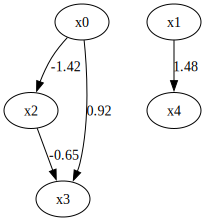

In [74]:
make_dot(B)

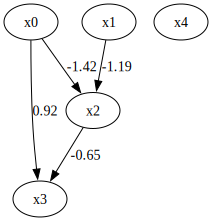

In [75]:
make_dot(B_perturbed)